In [4]:
#PART 1: Loadiing Packages

import yt
import pyxsim

import h5py
import numpy as np
import illustris_python as il
import glob
from numba import jit
from yt import derived_field

from tqdm import tqdm
import os
import pylab as plt
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor

soxs : [WARNING  ] 2025-05-19 18:40:14,955 Setting 'soxs_data_dir' to /home/tnguser/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [8]:
#PART 2: Simulation Specification
basePath = "../../../sims.TNG/TNG100-1/output/"
snap = 50                                          #z=1
nbins = 6
r_norm_max = 2
r_norm_min = 1e-2
max_workers = 3
tag = ["Efficient_AGN", "Efficient_Non", "Inefficient_AGN", "Inefficient_Non"]
hm = "ananya"

In [9]:
def process_single_halo(haloID, label):
    try:
        print(f"Processing {label} halo {haloID}...")
        halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)

        header = il.groupcat.loadHeader(basePath, snap)
        fields = ["Coordinates", "GFM_CoolingRate", "Density", "InternalEnergy", "ElectronAbundance", "StarFormationRate", "Masses", "GFM_Metallicity", "Velocities"]
        
        gas = il.snapshot.loadHalo(basePath, snap, haloID, "gas", fields=fields)
        with h5py.File(il.snapshot.snapPath(basePath, snap), 'r') as f:
            header_snap = dict(f['Header'].attrs)

        filename = f"halo_{label}_{haloID}.hdf5"
        with h5py.File(filename, 'w') as f:
            for key in gas.keys():
                f['PartType0/' + key] = gas[key]
            f.create_group('Header')
            f['Header'].attrs['NumFilesPerSnapshot'] = 1
            f['Header'].attrs['MassTable'] = header_snap['MassTable']
            f['Header'].attrs['BoxSize'] = header['BoxSize']
            f['Header'].attrs['Time'] = header['Time']
            f['Header'].attrs['Redshift'] = header['Redshift']
            f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])
            f['Header'].attrs['HubbleParam'] = header['HubbleParam']
            f['Header'].attrs['Omega0'] = header['Omega0']
            f['Header'].attrs['OmegaLambda'] = header['OmegaLambda']
            f['Header'].attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
            f['Header'].attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
            f['Header'].attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

        @yt.derived_field(name="radius_new", units="", sampling_type="cell", force_override=True)
        def _radius_new(field, data):
            r1 = np.linalg.norm(data["PartType0", "Coordinates"].to("kpc") - c, axis=1)
            return  r1 #/ r200
        
        @yt.derived_field(name="density_news", units="g/cm**3", sampling_type="cell", force_override=True)
        def _density_news(field, data):
            #r1 = np.linalg.norm(data["PartType0", "Coordinates"].to("kpc") - c, axis=1)
            dens = data["PartType0", "Density"].to("g/cm**3")
            return  dens #/ r200

        ds = yt.load(filename)

        c = ds.arr(halo["GroupPos"], "code_length").to("kpc")
        mass = ds.arr(halo["Group_M_Crit200"]) * 1e10/0.6774
        r200a = ds.arr(halo["Group_R_Crit200"], "code_length").to("kpc")
        r200 = r200a.to_value("kpc") 
        del halo, header, gas

        sp = ds.sphere(c, r_norm_max * r200)

        def get_radial_profiles(sp, fields_to_profile, nbins, r_norm_min, r_norm_max, weight_field):
            profiles = {}
            for field in fields_to_profile:
                prof = yt.Profile1D(sp, ("gas", "radius_new"), nbins, r_norm_min*r200, r_norm_max*r200, True, weight_field=weight_field)
                prof.add_fields([field])
                key = field[1]
                profiles[f"{key}_r"] = prof.x
                profiles[f"{key}_values"] = prof[field]
            return profiles

        fields_to_profile = [
            ("gas", "temperature"),
            ("gas", "entropy"),
            ("gas", "pressure"),
            ("gas", "density_news"),
            ("gas", "star_formation_rate"), 
            ("gas", "metallicity"),
        ]

        weight_field = ("gas", "mass")

        profiles_dict = get_radial_profiles(sp, fields_to_profile, nbins, r_norm_min, r_norm_max, weight_field)

        r_bin_center = profiles_dict["temperature_r"]
        #np.savez("rbins_mass.npz", r_bin_center = r_bin_center)
        temp = profiles_dict["temperature_values"]
        entropy = profiles_dict["entropy_values"]
        pressure = profiles_dict["pressure_values"]
        density = profiles_dict["density_news_values"]
        sfr = profiles_dict["star_formation_rate_values"]
        metal = profiles_dict["metallicity_values"]
        

        for f in [filename, filename + ".ewah"]:
            if os.path.exists(f):
                os.remove(f)

        return haloID, mass, r_bin_center, temp, entropy, pressure, density, sfr, metal

    except Exception as e:
        print(f"❌ Failed for halo {haloID}: {e}")
        return None

def combined_profiles(halo_list, label):
    i_all = []
    rad_all = []
    temp_all = []
    mass_all = []
    entropy_all = []
    pressure_all = []
    density_all = []
    sfr_all = []
    metal_all = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single_halo, haloID, label): haloID for haloID in halo_list}
        with tqdm(total=len(futures), desc=f"Processing {label} halos") as pbar:
            for future in as_completed(futures):
                result = future.result()
                if result:
                    i, ms,r, t, e, p, d, s, m = result
                    i_all.append(i)
                    mass_all.append(ms)
                    rad_all.append(r)
                    temp_all.append(t)
                    entropy_all.append(e)
                    pressure_all.append(p)
                    density_all.append(d)
                    sfr_all.append(s)
                    metal_all.append(m)
                pbar.update(1)

    # Convert lists to arrays
    i_all = np.array(i_all)
    mass_all = np.array(mass_all)
    rad_all = np.array(rad_all)
    temp_all = np.array(temp_all)
    entropy_all = np.array(entropy_all)
    pressure_all = np.array(pressure_all)
    density_all = np.array(density_all)
    sfr_all = np.array(sfr_all)
    metal_all = np.array(metal_all)

    np.savez(f"individual_profiles_hm{hm}_{label}.npz",
             haloIDnum=i_all,
             mhalo=mass_all,
             rad = rad_all,
             temperature=temp_all,
             entropy=entropy_all,
             pressure=pressure_all,
             density=density_all,
             sfr=sfr_all,
             metallicity=metal_all)

    print(f"✅ Saved individual_profiles_hm{hm}_{label}.npz")

In [ ]:
halo10 = [0,1,2,3,4,5,6,7,8,9]
combined_profiles(halo10, "puchchi")

/tmp/ipykernel_316/2005940659.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlGnBu")
/tmp/ipykernel_316/2005940659.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label="Halo Mass [Msun]")


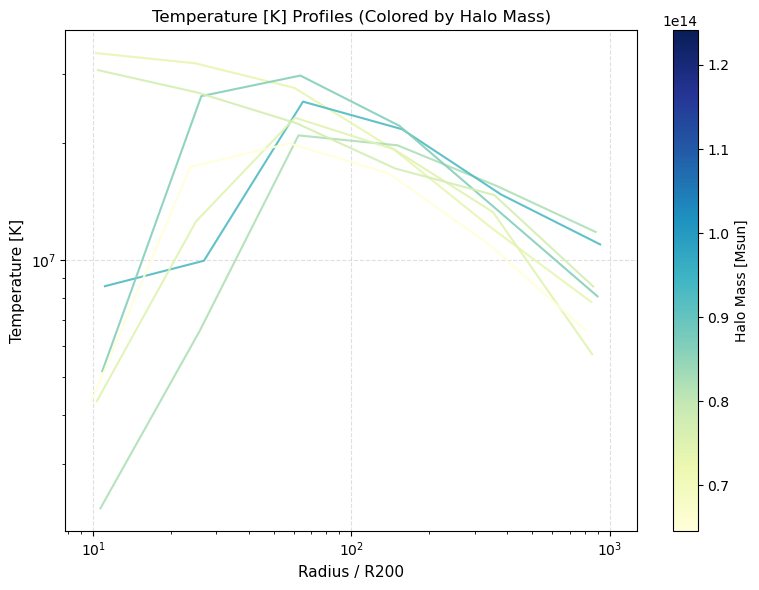

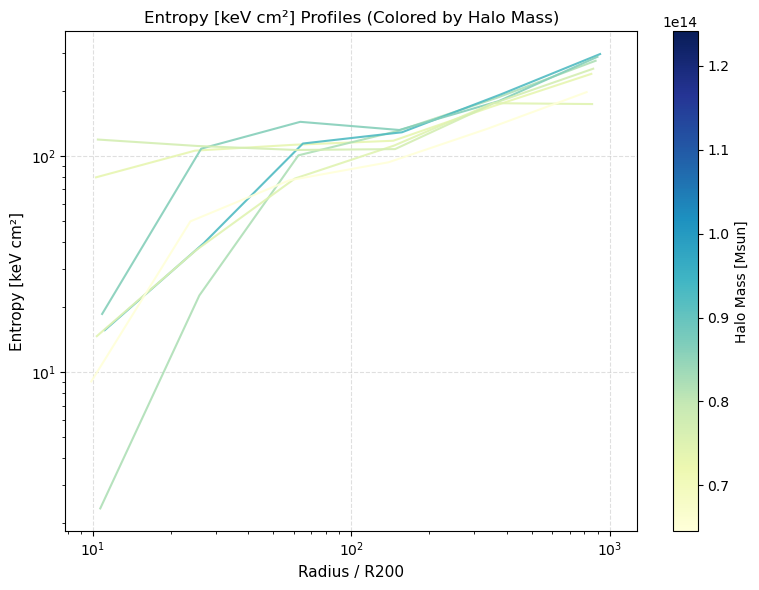

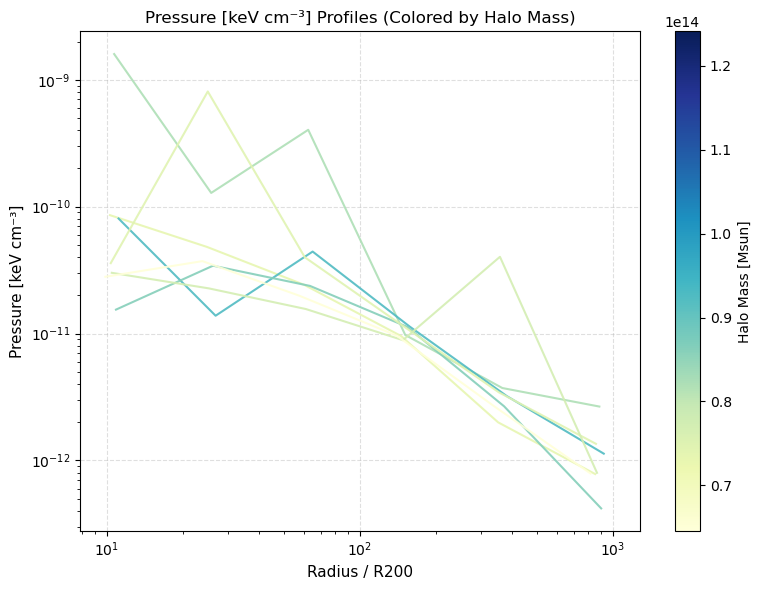

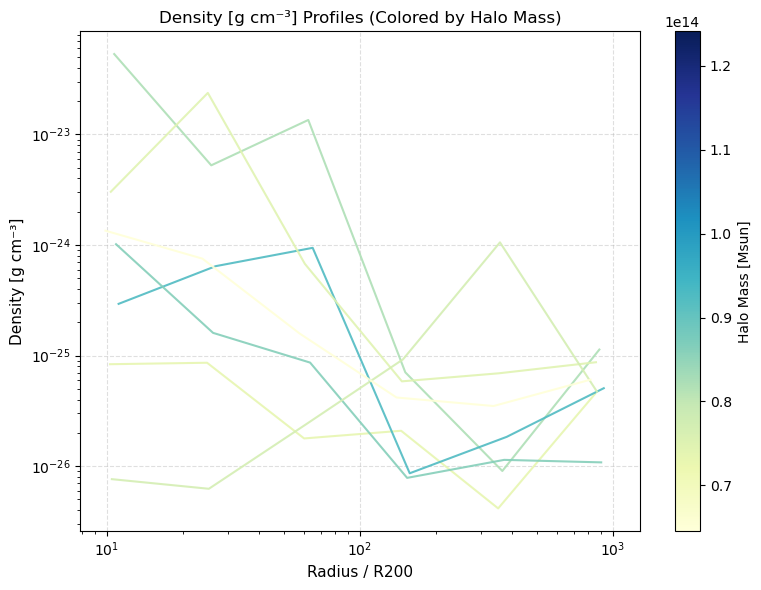

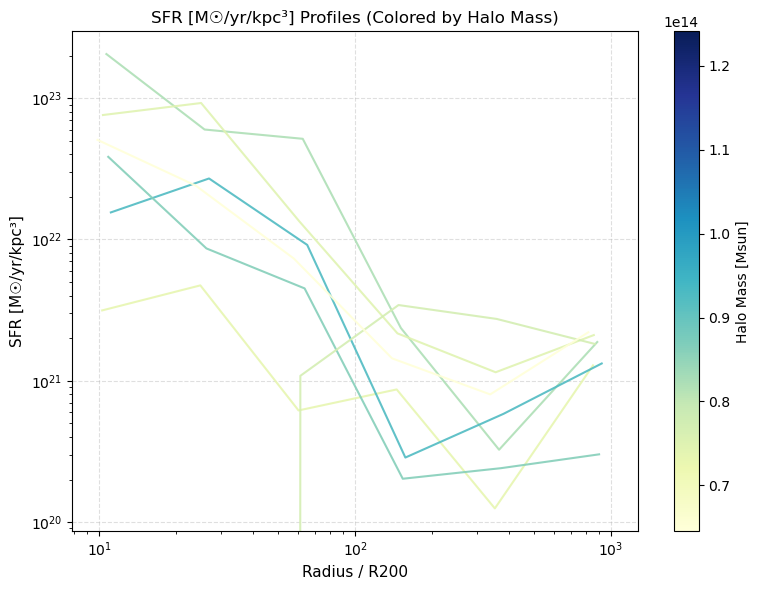

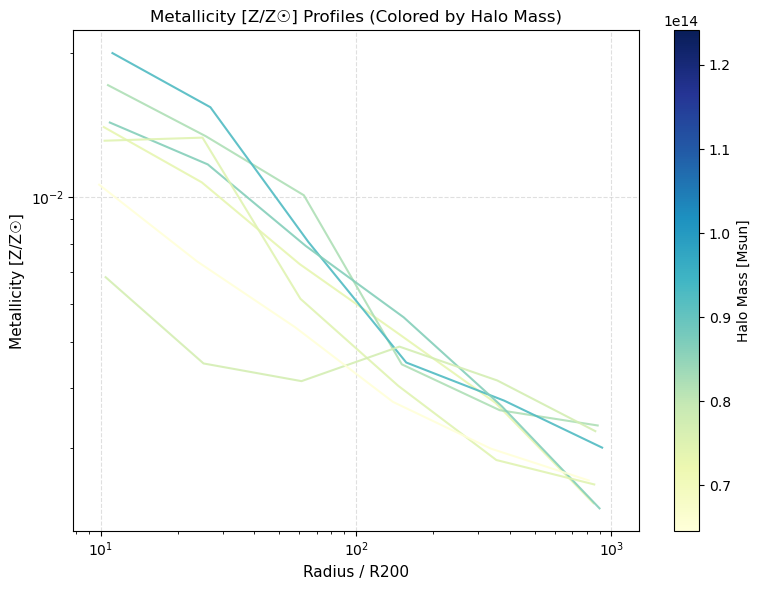

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

label = "puchchi"

def plot_profiles_by_mass(npz_file, label):
    data = np.load(npz_file)
    
    mhalo = data["mhalo"]
    rad_all = data["rad"]  # Individual radius arrays for each halo

    profiles = {
        "Temperature [K]": data["temperature"],
        "Entropy [keV cm²]": data["entropy"],
        "Pressure [keV cm⁻³]": data["pressure"],
        "Density [g cm⁻³]": data["density"],
        "SFR [M☉/yr/kpc³]": data["sfr"],
        "Metallicity [Z/Z☉]": data["metallicity"]
    }

    # Normalize halo masses to colormap: yellow = low mass, blue = high mass
    cmap = cm.get_cmap("YlGnBu")
    norm = mcolors.Normalize(vmin=np.min(mhalo), vmax=np.max(mhalo))

    for title, values in profiles.items():
        plt.figure(figsize=(8, 6))
        for i in range(len(mhalo)):
            r = rad_all[i]
            v = values[i]
            color = cmap(norm(mhalo[i]))
            plt.plot(r, v, color=color, linewidth=1.5, alpha=0.9)

        # Add colorbar
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, label="Halo Mass [Msun]")

        # Labels and formatting
        plt.xlabel("Radius / R200", fontsize=11)
        plt.ylabel(title, fontsize=11)
        plt.title(f"{title} Profiles (Colored by Halo Mass)", fontsize=12)
        plt.xscale("log")
        plt.yscale("log")
        plt.grid(True, ls="--", alpha=0.4)
        plt.tight_layout()

        # Save plot
        fname = f"profile_{label}_{title.replace(' ', '_').replace('/', '_')}.png"
        plt.savefig(fname, dpi=300)
        plt.show()

# Example call
plot_profiles_by_mass(f"individual_profiles_hm{hm}_{label}.npz", label)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
label = "puchchi"
def plot_profiles_by_mass(npz_file, label):
    data = np.load(npz_file)
    r = np.load("rbins_mass.npz")["r_bin_center"]
    mhalo = data["mhalo"]

    profiles = {
        "Temperature [K]": data["temperature"],
        "Entropy [keV cm²]": data["entropy"],
        "Pressure [keV cm⁻³]": data["pressure"],
        "Density [g cm⁻³]": data["density"],
        "SFR [M☉/yr/kpc³]": data["sfr"],
        "Metallicity [Z/Z☉]": data["metallicity"]
    }

    # Normalize halo masses to colormap: yellow = low mass, blue = high mass
    cmap = cm.get_cmap("YlGnBu")
    norm = mcolors.Normalize(vmin=np.min(mhalo), vmax=np.max(mhalo))

    for title, values in profiles.items():
        plt.figure(figsize=(8, 6))
        for i in range(len(mhalo)):
            color = cmap(norm(mhalo[i]))
            plt.plot(r, values[i], color=color, linewidth=1.5, alpha=0.9)

        # Add colorbar
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, label="Halo Mass [Msun]")

        # Labels and formatting
        plt.xlabel("Radius / R200", fontsize=11)
        plt.ylabel(title, fontsize=11)
        plt.title(f"{title} Profiles (Colored by Halo Mass)", fontsize=12)
        plt.xscale("log")
        plt.yscale("log")
        plt.grid(True, ls="--", alpha=0.4)
        plt.tight_layout()

        # Save plot
        fname = f"profile_{label}_{title.replace(' ', '_').replace('/', '_')}.png"
        plt.savefig(fname, dpi=300)
        plt.show()

# Example call
plot_profiles_by_mass(f"individual_profiles_hm{hm}_{label}.npz", label)


/tmp/ipykernel_3203/786515246.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlGnBu")


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
from matplotlib.colors import Normalize
from matplotlib import cm
label = "puchchi"
def plot_profiles(y_data, halo_ids, r, ylabel, title, filename_prefix):
    num_halos = len(halo_ids)

    # Reverse colormap: yellow → blue becomes blue → yellow
    cmap = cm.get_cmap("YlGnBu_r")
    norm = Normalize(vmin=min(halo_ids), vmax=max(halo_ids))

    for i in range(0, num_halos, 10):
        fig, ax = plt.subplots(figsize=(8, 6))
        for j in range(10):
            idx = i + j
            if idx >= num_halos:
                break
            color = cmap(norm(halo_ids[idx]))  # blue for lowest halo ID
            ax.plot(r, y_data[idx], label=f"Halo {halo_ids[idx]}", color=color, linewidth=1)

        ax.set_xscale("log")
        ax.set_yscale("log")
        #ax.set_ylim(ylim)
        ax.set_xlabel("r / R200", fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(f"{title} (Halos {i}–{min(i+9, num_halos)})", fontsize=14)
        ax.legend(fontsize=8)
        ax.grid(True,alpha = 0.15, ls="--", linewidth=0.5)
        plt.tight_layout()
        plt.savefig(f"{filename_prefix}_group{i//10 + 1}.png", dpi=300)
        plt.show()
plot_profiles(temperature, halo_ids, r, ylabel="Temperature", title="Temperature Profiles", filename_prefix="temperature")
plot_profiles(entropy, halo_ids, r, ylabel="Entropy", title="Entropy Profiles", filename_prefix="entropy")
#plot_profiles(pressure, halo_ids, r, ylabel="Pressure", title="Pressure Profiles", filename_prefix="pressure")
plot_profiles(density, halo_ids, r, ylabel="Density", title="Density Profiles", filename_prefix="density")
#plot_profiles(sfr, halo_ids, r, ylabel="Star Formation Rate", title="SFR Profiles", filename_prefix="sfr")
#plot_profiles(metallicity, halo_ids, r, ylabel="Metallicity", title="Metallicity Profiles", filename_prefix="metallicity")

In [ ]:
from matplotlib.colors import Normalize
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

# Your halo masses (for halo 0–9)
halo_mass = np.array([
    14.093844,
    14.020556,
    13.864481,
    13.913938,
    13.912876,
    13.96622,
    13.935586,
    13.873575,
    13.885953,
    13.809872
])

def plot_profiles(y_data, halo_ids, halo_mass, r, ylabel, title, filename_prefix):
    num_halos = len(halo_ids)

    # Colormap: higher mass = blue, lower = yellow
    cmap = cm.get_cmap("YlGnBu_r")
    norm = Normalize(vmin=min(halo_mass), vmax=max(halo_mass))

    for i in range(0, num_halos, 10):
        fig, ax = plt.subplots(figsize=(8, 6))
        for j in range(10):
            idx = i + j
            if idx >= num_halos:
                break
            color = cmap(norm(halo_mass[idx]))
            ax.plot(r, y_data[idx], label=f"Halo {halo_ids[idx]}", color=color, linewidth=1)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("r / R200", fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(f"{title} (Halos {i}–{min(i+9, num_halos)})", fontsize=14)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.15, ls="--", linewidth=0.5)
        plt.tight_layout()
        plt.savefig(f"{filename_prefix}_group{i//10 + 1}.png", dpi=300)
        plt.show()

# Load data
data = np.load("individual_profiles_hmananya_puchchi.npz", allow_pickle=True)
halo_ids = data["haloIDnum"]
r = np.load("rbins_mass.npz")["r_bin_center"]
temperature = data["temperature"]
entropy = data["entropy"]
density = data["density"]

# Call function
plot_profiles(temperature, halo_ids, halo_mass, r, ylabel="Temperature", title="Temperature Profiles", filename_prefix="temperature")
plot_profiles(entropy, halo_ids, halo_mass, r, ylabel="Entropy", title="Entropy Profiles", filename_prefix="entropy")
plot_profiles(density, halo_ids, halo_mass, r, ylabel="Density", title="Density Profiles", filename_prefix="density")


In [ ]:
halo = il.groupcat.loadHalos(basePath, snap, fields =['Group_M_Crit200', 'GroupFirstSub'])

Mhalo = halo['Group_M_Crit200'] * 1e10 / 0.6774

In [ ]:
for i in range(0,10):
    print(np.log10(Mhalo[i]), ",")
    
[14.093844 ,
14.020556 ,
13.864481 ,
13.913938 ,
13.912876 ,
13.96622 ,
13.935586 ,
13.873575 ,
13.885953 ,
13.809872]

In [ ]:
#PART 4B:: Usage: Calculate avg and std of mean of all halo profiles of same halo labels and save in 4 different npz
'''
data = np.load(f"accretor_agn100_hm{hm}.npz")

combined_profiles(data["ha_agn"], tag[0])
combined_profiles(data["hn_agn"], tag[2])
combined_profiles(data["hn_non"], tag[3])
'''
data1 = np.load(f"accretor_agn100_hm1.npz")
data2 = np.load(f"accretor_agn100_hm2.npz")
data3 = np.load(f"accretor_agn100_hm3.npz")
data4 = np.load(f"accretor_agn100_hm4.npz")
data5 = np.load(f"accretor_agn100_hm5.npz")
data6 = np.load(f"accretor_agn100_hm6.npz")

combined_profiles(data6["ha_agn"], tag[0], "6")
combined_profiles(data6["hn_agn"], tag[2], "6")
combined_profiles(data6["hn_non"], tag[3], "6")

combined_profiles(data5["ha_agn"], tag[0], "5")
combined_profiles(data5["hn_agn"], tag[2], "5")
combined_profiles(data5["hn_non"], tag[3], "5")

combined_profiles(data4["ha_agn"], tag[0], "4")
combined_profiles(data4["hn_agn"], tag[2], "4")
combined_profiles(data4["hn_non"], tag[3], "4")

combined_profiles(data3["ha_agn"], tag[0], "3")
combined_profiles(data3["hn_agn"], tag[2], "3")
combined_profiles(data3["hn_non"], tag[3], "3")

combined_profiles(data2["ha_agn"], tag[0], "2")
combined_profiles(data2["hn_agn"], tag[2], "2")
combined_profiles(data2["hn_non"], tag[3], "2")

combined_profiles(data1["ha_agn"], tag[0], "1")
combined_profiles(data1["hn_agn"], tag[2], "1")
combined_profiles(data1["hn_non"], tag[3], "1")

In [ ]:
# PART 5: Plot Thermodynamical Profiles (with 3 labels in each)

#bin_edges = np.linspace(0, r_norm_max, nbins + 1)
#bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

bin_edges = np.logspace(np.log10(r_norm_min), np.log10(r_norm_max), nbins + 1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

#hm = "3"
#hmn = r"$10^{12.5} \leq M_{\rm halo} < 10^{13} \, M_\odot$"

hmv = ["1", "2", "3", "4", "5", "6"]

hmname = [
    r"$10^{11} \leq M_{\rm halo} < 10^{11.5} \, M_\odot$",
    r"$10^{11.5} \leq M_{\rm halo} < 10^{12} \, M_\odot$",
    r"$10^{12} \leq M_{\rm halo} < 10^{12.5} \, M_\odot$",
    r"$10^{12.5} \leq M_{\rm halo} < 10^{13} \, M_\odot$",
    r"$10^{13} \leq M_{\rm halo} < 10^{13.5} \, M_\odot$",
    r"$10^{13.5} \leq M_{\rm halo} \, (M_\odot)$"
]


for hm, hmn in zip(hmv, hmname):
    profiles_ha_agn = np.load(f"combined100ytm_hm{hm}_{tag[0]}.npz")
    profiles_hn_agn = np.load(f"combined100ytm_hm{hm}_{tag[2]}.npz")
    profiles_hn_non = np.load(f"combined100ytm_hm{hm}_{tag[3]}.npz")

    data = np.load(f"accretor_agn100_hm{hm}.npz")          #ha_agn, ha_non, hn_agn, hn_non ids
    ha_agn = data["ha_agn"]
    hn_agn = data["hn_agn"]
    hn_non = data["hn_non"]

    def plot_quantity(quantity, ylabel, filename):

        avg_ha_agn = profiles_ha_agn[f"{quantity}_mean"]
        err_ha_agn = profiles_ha_agn[f"{quantity}_sem"]

        avg_hn_agn = profiles_hn_agn[f"{quantity}_mean"]
        err_hn_agn = profiles_hn_agn[f"{quantity}_sem"]

        avg_hn_non = profiles_hn_non[f"{quantity}_mean"]
        err_hn_non = profiles_hn_non[f"{quantity}_sem"]

        plt.figure(figsize=(8, 6))

        # Efficient Accretors - AGN
        plt.plot(bin_centers, avg_ha_agn.flatten(), label=f"Efficiently Accreting AGNs (N={len(ha_agn)})", color="red")
        plt.fill_between(bin_centers, (avg_ha_agn - err_ha_agn).flatten(), (avg_ha_agn + err_ha_agn).flatten(), color="red", alpha=0.3)


        # Inefficient Accretors - AGN
        plt.plot(bin_centers, avg_hn_agn.flatten(), label=f"Inefficiently Accreting AGNs (N={len(hn_agn)})", color="green")
        plt.fill_between(bin_centers, (avg_hn_agn - err_hn_agn).flatten(), (avg_hn_agn + err_hn_agn).flatten(), color="green", alpha=0.3)

        # Inefficient Accretors - Non-AGN
        plt.plot(bin_centers, avg_hn_non.flatten(), label=f"Non-AGNs (N={len(hn_non)})", color="black")
        plt.fill_between(bin_centers, (avg_hn_non - err_hn_non).flatten(), (avg_hn_non + err_hn_non).flatten(),color="black", alpha=0.15)
 
        plt.xlabel("r / r200")
        plt.ylabel(ylabel)
        plt.title(f"Stacked Radial {ylabel} Profile (TNG100-1, z = 1, {hmn})")
        plt.legend(fontsize=12)
        plt.grid(True)
        #plt.xlim(1, 2)
        #plt.ylim(ylim)
        plt.xscale("log")
        plt.yscale("log")
        plt.tight_layout()
        plt.savefig(filename, dpi=900)
        plt.show()

    # Call the plot function for each physical quantity
    plot_quantity("temperature", "Average Temperature [K]", f"temperature100_{hm}.png")
    plot_quantity("entropy", "Average Entropy [keV cm²]", f"entropy100_{hm}.png")
    plot_quantity("pressure", "Average Pressure [dyne/cm²]", f"pressure100_{hm}.png")
    plot_quantity("density", "Average Density [g/cm³]", f"density100_{hm}.png")
    plot_quantity("sfr", "Average Star Formation Rate [g/s]", f"sfr100_{hm}.png")
    plot_quantity("metal", "Average Metallicity", f"metal100_{hm}.png")

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

print("puchii")

quantities = ["temperature", "entropy", "pressure", "density", "sfr", "metal"]
hms = ["1", "2", "3", "4", "5", "6"]
hm_labels = [
    r"$10^{11} - 10^{11.5} \, M_\odot$",
    r"$10^{11.5} - 10^{12} \, M_\odot$",
    r"$10^{12} - 10^{12.5} \, M_\odot$",
    r"$10^{12.5} - 10^{13} \, M_\odot$",
    r"$10^{13} - 10^{13.5} \, M_\odot$",
    r"$> 10^{13.5} \, M_\odot$"
]


fig, axes = plt.subplots(len(quantities), len(hms), figsize=(15, 17))

for i, quantity in enumerate(quantities):
    for j, hm in enumerate(hms):
        filename = f"{quantity}100_{hm}.png"
        try:
            img = Image.open(filename)
            ax = axes[i, j]
            ax.imshow(np.asarray(img))
            ax.axis('off')
            if i == 0:
                ax.set_title(hm_labels[j], fontsize=13)
            if j == 0:
                ax.set_ylabel(quantity.capitalize(), fontsize=10)
        except Exception as e:
            print(f"Could not load {filename}: {e}")
            axes[i, j].axis('off')

# Add a super title
fig.suptitle("Thermodynamic Stacked Radial Profiles (TNG100-1, z = 1)", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for supertitle
plt.savefig("tng100_ytm.pdf", dpi=1200)

plt.show()


In [23]:
from astropy.cosmology import Planck18  # or your custom cosmology
import astropy.units as u

a1 = 0.50
a2 = 0.52

z1 = (1/a1) -1
z2 = (1/a2) -1

# Define redshift
#z = 0.7  # example redshift

# Compute age of the universe at redshift z
time_diff = Planck18.age(z2) - Planck18.age(z1) 

print(f"Time run for snapshot z = 1 is {time_diff:.2f}")

Time run for snapshot z = 1 is 0.33 Gyr


In [ ]:
halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)

header = il.groupcat.loadHeader(basePath, snap)
fields = ["Coordinates", "GFM_CoolingRate", "Density", "InternalEnergy", "ElectronAbundance", "StarFormationRate", "Masses", "GFM_Metallicity", "Velocities"]

gas = il.snapshot.loadHalo(basePath, snap, haloID, "gas", fields=fields)
with h5py.File(il.snapshot.snapPath(basePath, snap), 'r') as f:
    header_snap = dict(f['Header'].attrs)

filename = f"halo_{label}_{haloID}.hdf5"
with h5py.File(filename, 'w') as f:
    for key in gas.keys():
        f['PartType0/' + key] = gas[key]
    f.create_group('Header')
    f['Header'].attrs['NumFilesPerSnapshot'] = 1
    f['Header'].attrs['MassTable'] = header_snap['MassTable']
    f['Header'].attrs['BoxSize'] = header['BoxSize']
    f['Header'].attrs['Time'] = header['Time']
    f['Header'].attrs['Redshift'] = header['Redshift']
    f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])
    f['Header'].attrs['HubbleParam'] = header['HubbleParam']
    f['Header'].attrs['Omega0'] = header['Omega0']
    f['Header'].attrs['OmegaLambda'] = header['OmegaLambda']
    f['Header'].attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
    f['Header'].attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
    f['Header'].attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

@yt.derived_field(name="radius_new", units="", sampling_type="cell", force_override=True)
def _radius_new(field, data):
    r1 = np.linalg.norm(data["PartType0", "Coordinates"].to("kpc") - c, axis=1)
    return  r1 #/ r200

@yt.derived_field(name="density_news", units="g/cm**3", sampling_type="cell", force_override=True)
def _density_news(field, data):
    #r1 = np.linalg.norm(data["PartType0", "Coordinates"].to("kpc") - c, axis=1)
    dens = data["PartType0", "Density"].to("g/cm**3")
    return  dens #/ r200

ds = yt.load(filename)

c = ds.arr(halo["GroupPos"], "code_length").to("kpc")
mass = ds.arr(halo["Group_M_Crit200"]) * 1e10/0.6774
r200a = ds.arr(halo["Group_R_Crit200"], "code_length").to("kpc")
r200 = r200a.to_value("kpc") 
del halo, header, gas

sp = ds.sphere(c, r_norm_max * r200)

def get_radial_profiles(sp, fields_to_profile, nbins, r_norm_min, r_norm_max, weight_field):
    profiles = {}
    for field in fields_to_profile:
        prof = yt.Profile1D(sp, ("gas", "radius_new"), nbins, r_norm_min*r200, r_norm_max*r200, True, weight_field=weight_field)
        prof.add_fields([field])
        key = field[1]
        profiles[f"{key}_r"] = prof.x
        profiles[f"{key}_values"] = prof[field]
    return profiles

fields_to_profile = [
    ("gas", "temperature"),
    ("gas", "entropy"),
    ("gas", "pressure"),
    ("gas", "density_news"),
    ("gas", "star_formation_rate"), 
    ("gas", "metallicity"),
]

weight_field = ("gas", "mass")

profiles_dict = get_radial_profiles(sp, fields_to_profile, nbins, r_norm_min, r_norm_max, weight_field)

r_bin_center = profiles_dict["temperature_r"]
#np.savez("rbins_mass.npz", r_bin_center = r_bin_center)
temp = profiles_dict["temperature_values"]
entropy = profiles_dict["entropy_values"]
pressure = profiles_dict["pressure_values"]
density = profiles_dict["density_news_values"]
sfr = profiles_dict["star_formation_rate_values"]
metal = profiles_dict["metallicity_values"]

In [21]:
from illustris_python import snapshot
'''
halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)

header = il.groupcat.loadHeader(basePath, snap)
fields = ["Coordinates", "GFM_CoolingRate", "Density", "InternalEnergy", "ElectronAbundance", "StarFormationRate", "Masses", "GFM_Metallicity", "Velocities"]

gas = il.snapshot.loadHalo(basePath, snap, haloID, "gas", fields=fields)

# Arguments: basePath, snapNum, partType, fields
basePath = '/path/to/illustris/data'
snapNum = 99  # or whichever snapshot you're using
'''
basePath = "../../../sims.TNG/TNG100-1/output/"
snap = 50  
density  = il.snapshot.loadHalo(basePath, snap,5, partType=0, fields=['Density'])
print(density.to(g/cm**3))

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [29]:
haloID = 678

halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)

header = il.groupcat.loadHeader(basePath, snap)
fields = ["Coordinates", "GFM_CoolingRate", "Density", "InternalEnergy", "ElectronAbundance", "StarFormationRate", "Masses", "GFM_Metallicity", "Velocities"]

gas = il.snapshot.loadHalo(basePath, snap, haloID, "gas", fields=fields)
with h5py.File(il.snapshot.snapPath(basePath, snap), 'r') as f:
    header_snap = dict(f['Header'].attrs)

filename = f"halo_{label}_{haloID}.hdf5"
with h5py.File(filename, 'w') as f:
    for key in gas.keys():
        f['PartType0/' + key] = gas[key]
    f.create_group('Header')
    f['Header'].attrs['NumFilesPerSnapshot'] = 1
    f['Header'].attrs['MassTable'] = header_snap['MassTable']
    f['Header'].attrs['BoxSize'] = header['BoxSize']
    f['Header'].attrs['Time'] = header['Time']
    f['Header'].attrs['Redshift'] = header['Redshift']
    f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])
    f['Header'].attrs['HubbleParam'] = header['HubbleParam']
    f['Header'].attrs['Omega0'] = header['Omega0']
    f['Header'].attrs['OmegaLambda'] = header['OmegaLambda']
    f['Header'].attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
    f['Header'].attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
    f['Header'].attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

ds = yt.load(filename)

c = ds.arr(halo["GroupPos"], "code_length").to("kpc")
mass = ds.arr(halo["Group_M_Crit200"]) * 1e10/0.6774
r200a = ds.arr(halo["Group_R_Crit200"], "code_length").to("kpc")
r200 = r200a.to_value("kpc") 
del halo, header, gas

sp = ds.sphere(c, r_norm_max * r200)

print(sp["PartType0", "Density"])
print(sp["gas", "density"])

yt : [INFO     ] 2025-05-19 19:59:08,703 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 19:59:08,777 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 19:59:08,778 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 19:59:08,780 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 19:59:08,781 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 19:59:08,782 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 19:59:08,782 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 19:59:08,783 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 19:59:08,783 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 19:59:08,784 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 19:59:08,785 Parameters: hubble_consta

[1.27653341e-24 7.56271936e-26 2.97961173e-26 ... 1.52143870e-25
 1.61700581e-25 1.77482032e-25] g/cm**3
[1.27653341e-24 7.56271936e-26 2.97961173e-26 ... 1.52143870e-25
 1.61700581e-25 1.77482032e-25] g/cm**3


In [ ]:
[5.15742227e-04 3.05547328e-05 1.20381619e-05 ... 6.14688324e-05
 6.53299139e-05 7.17059011e-05] code_mass/code_length**3



In [33]:
print(sp["PartType0", "Coordinates"])


[[25344.81282278 52548.20917678 41714.70631518]
 [25347.83837717 52542.60202675 41713.63847572]
 [25348.71402702 52542.91266462 41717.05974741]
 ...
 [25344.53118594 52548.02352563 41716.09531828]
 [25342.49990244 52525.03474351 41727.01685679]
 [25343.00115326 52548.74668064 41720.47046803]] code_length
